<h2 style='text-align: center'> Importing the libraries </h2>

In [29]:
import numpy as np
import time
import os
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import cv2 
import multiprocessing as mp
import imp
import threading


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


<h2 style='text-align: center'> Preparing the dataset </h2>

In [31]:
multi_traindata = pd.read_csv('text_dataset_train.tsv',sep='\t')
multi_validata = pd.read_csv('text_dataset_val.tsv',sep='\t')
multi_testdata = pd.read_csv('text_dataset_test.tsv',sep='\t')

In [32]:
train_data = multi_traindata[multi_traindata['title'].notna()]

valid_data = multi_validata[multi_validata['title'].notna()]

test_data = multi_testdata[multi_testdata['title'].notna()]

In [33]:
len(train_data), len(valid_data), len(test_data)

(43793, 5474, 5475)

In [34]:
train_news, train_labels, train_images = train_data['title'].tolist(), train_data['6_way_label'].tolist(), train_data['id'].tolist()
valid_news, valid_labels, valid_images = valid_data['title'].tolist(), valid_data['6_way_label'].tolist(), valid_data['id'].tolist()
test_news, test_labels, test_images = test_data['title'].tolist(), test_data['6_way_label'].tolist(), test_data['id'].tolist()

In [35]:
def add_suffix(images, suffix='.jpg'):
    return [image + suffix for image in images]

train_images_final = add_suffix(train_images)
valid_images_final = add_suffix(valid_images)
test_images_final = add_suffix(test_images)

<h2 style='text-align: center'> Preparing the text data </h2>

In [36]:
import re
def preprocess_text(sentence):
    return re.sub(r'[^a-zA-Z\s]|\s+', ' ', sentence)

In [37]:
train_news_clean = [preprocess_text(new) for new in train_news]
valid_news_clean = [preprocess_text(new) for new in valid_news]
test_news_clean = [preprocess_text(new) for new in test_news]

In [38]:
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

def remove_stopwords_lem(text):
    text = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word, pos = get_wordnet_pos(word)) for word in text if word not in stop_words]
    filtered_words
    return ' '.join(filtered_words)


from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1]
    tag
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [39]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')

train_stwrd_lem = [remove_stopwords_lem(new) for new in train_news_clean]
valid_stwrd_lem = [remove_stopwords_lem(new) for new in valid_news_clean]
test_stwrd_lem = [remove_stopwords_lem(new) for new in test_news_clean]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem
tokenizer = Tokenizer(num_words = 128022)
tokenizer.fit_on_texts(news_all)
train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)

In [41]:

print("Vocabulary length: ", len(tokenizer.word_index))

Vocabulary length:  36538


In [42]:

train_tokenized_padding = pad_sequences(train_tokenized, maxlen = 15, truncating='post', padding='post')

valid_tokenized_padding = pad_sequences(valid_tokenized, maxlen = 15, truncating='post', padding='post')

test_tokenized_padding = pad_sequences(test_tokenized, maxlen = 15, truncating='post', padding='post')

In [43]:
def load_embedd(filename):
    words = []
    vectors = []
    with open(filename,'r', encoding="utf8") as file:
        for line in file:
           row = line.split(' ')
           vocab = row[0]
           embd = list(map(float, row[1:-1]))
           words.append(vocab)
           vectors.append(embd)
           words, vectors
    return words, vectors

In [44]:
def embed_matrix(word_index, vocab, embeddings, vocab_len, embedding_len):
    embedding_matrix = np.zeros((vocab_len + 1, embedding_len))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector = embeddings[idx]
            vector = np.pad(vector, (0, embedding_len - len(vector)), 'constant')
            embedding_matrix[i] = vector
    return embedding_matrix

In [45]:
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "glove.6B.300d.txt") # glove embeddings

In [46]:
word_index = tokenizer.word_index
embedding_matrix_gv_300 = embed_matrix(word_index=word_index, vocab=vocab_gv_300, embeddings=vectors_gv_300,
vocab_len=110688, embedding_len=300)

<h2 style='text-align: center'> Preparing the image data </h2>

In [47]:
all_images = os.listdir("image_dataset/")
path = "image_dataset/"


print("length all_images:",len(all_images))

length all_images: 54742


In [48]:
def pad_images(image):
    h, w, c = image.shape
    img_reshaped = np.zeros((3, 560, 560))
    rh = min(h, 560)
    rw = min(w, 560)
    img_reshaped[0, :rh, :rw] = image[:rh, :rw, 0]
    img_reshaped[1, :rh, :rw] = image[:rh, :rw, 1]
    img_reshaped[2, :rh, :rw] = image[:rh, :rw, 2]
    return img_reshaped

<h2 style='text-align: center'> Defining the model </h2>

In [49]:

class CNN(nn.Module):
    
    def __init__(self, image_dimx, nlabels):
        super().__init__()
        
        self.title_embedding = nn.Embedding(
            num_embeddings=110688,
            embedding_dim=300
        )
        self.title_embedding.weight = nn.Parameter(
            torch.from_numpy(embedding_matrix_gv_300),
            requires_grad=False
        )
        
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 3, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.title_cnn = nn.ModuleList([
            nn.Conv2d(1, 50, (k, 300), padding=(k-1,0))
            for k in [2, 3, 4, 5]
        ])
        
        self.fc1 = nn.Linear(200 + 3 * 137 * 137, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, nlabels)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.final_image_dim = int(((image_dimx - 4) / 2 - 4) / 2)

    def forward(self, image, title):
        image = self.image_cnn(image)
        image = image.view(image.shape[0], self.final_image_dim * self.final_image_dim * 3)

        title = self.title_embedding(title)
        title = title.unsqueeze(1)
        title = [F.relu(conv(title.float())).squeeze(3) for conv in self.title_cnn]
        title = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in title] 
        title = torch.cat(title, 1)
        
        x = torch.cat([image, title], 1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x

In [50]:
model = CNN(image_dimx=560, nlabels=6).to(device)

<h2 style='text-align: center'> Training the Model </h2>

In [51]:
counter = 0
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
train_accuracy = 0
train_batches_processed = 0

images_tensor = torch.zeros(60, 3, 560, 560)
titles_tensor = torch.zeros(60, 15)
labels_tensor = torch.zeros(60)

images_tensor = images_tensor.to(device)
titles_tensor = titles_tensor.to(device)
labels_tensor = labels_tensor.to(device)

for i in range(len(train_images_final)):
    
    img = cv2.imread(os.path.join(path, train_images_final[i])) 
        
    if type(img) is not type(None):
        counter += 1 
        
        img_padded = pad_images(img)

        images_tensor = images_tensor.to(device)
        titles_tensor = titles_tensor.to(device)
        labels_tensor = labels_tensor.to(device)
        
        images_tensor[counter-1, :,:,:] = torch.from_numpy(img_padded)
        titles_tensor[counter-1, :] = torch.from_numpy(train_tokenized_padding[i]).int()
        labels_tensor[counter - 1] = train_labels[i]
           
        
        if counter % 60 == 0: 
            train_batches_processed += 1
            print("Training Batch Processed: ", train_batches_processed)

            images_tensor = images_tensor.to(device)
            titles_tensor = titles_tensor.to(device)
            labels_tensor = labels_tensor.to(device)

            optimizer.zero_grad() 

            out = model.forward(images_tensor, titles_tensor.long())            
            loss = criterion(out, labels_tensor.long())
            
            loss.backward()
        
            optimizer.step()
            
            top_p, top_class = out.topk(1, dim=1) 
            equals = (top_class == labels_tensor.view(images_tensor.shape[0], 1))
            train_accuracy += torch.mean(equals.type(torch.FloatTensor))

            images_tensor = torch.zeros(60, 3, 560, 560)
            titles_tensor = torch.zeros(60, 15)
            labels_tensor = torch.zeros(60)
            
            counter = 0 
                
            if train_batches_processed % 100 == 0:

                print("Average Training Accuracy:", train_accuracy / train_batches_processed)

Training Batch Processed:  1
Training Batch Processed:  2
Training Batch Processed:  3
Training Batch Processed:  4
Training Batch Processed:  5
Training Batch Processed:  6
Training Batch Processed:  7
Training Batch Processed:  8
Training Batch Processed:  9
Training Batch Processed:  10
Training Batch Processed:  11
Training Batch Processed:  12
Training Batch Processed:  13
Training Batch Processed:  14
Training Batch Processed:  15
Training Batch Processed:  16
Training Batch Processed:  17
Training Batch Processed:  18
Training Batch Processed:  19
Training Batch Processed:  20
Training Batch Processed:  21
Training Batch Processed:  22
Training Batch Processed:  23
Training Batch Processed:  24
Training Batch Processed:  25
Training Batch Processed:  26
Training Batch Processed:  27
Training Batch Processed:  28
Training Batch Processed:  29
Training Batch Processed:  30
Training Batch Processed:  31
Training Batch Processed:  32
Training Batch Processed:  33
Training Batch Proc

<h2 style='text-align: center'> Testing the Model </h2>

In [68]:
counter = 0
batch_size = 60
images_tensor = torch.zeros(batch_size, 3, 560, 560).to(device)
titles_tensor = torch.zeros(batch_size, 15).int().to(device)
labels_tensor = torch.zeros(batch_size).int().to(device)

predictions = []
labels_test = []

with torch.no_grad():
    for i in range(len(test_images_final)):
        img = cv2.imread(path + test_images_final[i])
        if type(img) is not type(None):
            counter += 1
            img_padded = pad_images(img)
            images_tensor[counter - 1, :, :, :] = torch.from_numpy(img_padded).to(device)
            titles_tensor[counter - 1, :] = torch.from_numpy(test_tokenized_padding[i]).to(device)
            labels_tensor[counter - 1] = test_labels[i]
            if counter % batch_size == 0:
                out = model(images_tensor, titles_tensor)
                top_p, top_class = out.topk(1, dim=1)
                predictions.extend(top_class.cpu().numpy().flatten().tolist())
                labels_test.extend(labels_tensor.cpu().numpy().tolist())
                images_tensor = torch.zeros(batch_size, 3, 560, 560).to(device)
                titles_tensor = torch.zeros(batch_size, 15).int().to(device)
                labels_tensor = torch.zeros(batch_size).int().to(device)
                counter = 0
    if counter > 0:
        out = model(images_tensor[:counter, ...], titles_tensor[:counter, ...])
        top_p, top_class = out.topk(1, dim=1)
        predictions.extend(top_class.cpu().numpy().flatten().tolist())
        labels_test.extend(labels_tensor[:counter].cpu().numpy().tolist())

predictions = np.array(predictions)
labels_test = np.array(labels_test)


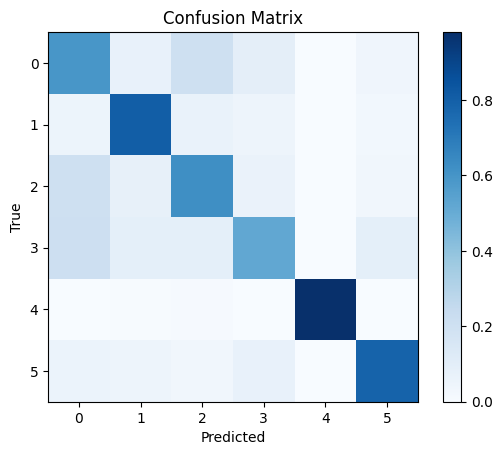

In [69]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(np.array(labels_test).reshape(len(labels_test),1),predictions)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

In [71]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(np.array(labels_test).reshape(len(labels_test),1),predictions)

print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 71.85%


<h2 style='text-align: center'> Saving the Model </h2>

In [61]:
torch.save(model.state_dict(), 'week4.pth')